# Deep Q-Network (DQN)

In [1]:
import os
import gym
import time
import random
import pickle
import numpy as np
from collections import deque
from operator import itemgetter
from progressbar import progressbar
from keras.models import Sequential, load_model
from keras.layers import Dense
import matplotlib.pyplot as plt

plt.style.use('seaborn')

/Users/Admin/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class DQN(object):
    """Deep Q-network training and testing framework.
    
    Parameters
    ----------
    env_id : str
        Gym environment ID.
    
    render : boolean, default: True
        Whether to render the environment at each step.
    
    gamma : float, default: 0.99
        Discount factor.
    
    eps : float, default: 1.0
        Initial value of epsilon in epsilon-greedy exploration.
    
    eps_min : float, default: 0.1
        Final value of epsilon in epsilon-greedy exploration.
    
    final_expl_step : int, default: 10000
        Number of time steps over which the initial value of epsilon is annealed to its
        final value.
    
    mb_size : int, default: 32
        Number of training examples that stochastic gradient descent passes through at
        each replay.
    
    C : int, default: 100
        Target network update frequency.
    
    n_episodes : int, default: 500
        Number of episodes for the agent to learn from.
    
    max_steps : int, default: 500
        Number of time steps to run in each learning episode.
    """
    
    def __init__(self, env_id, render=True, gamma=0.99, eps=1.0, eps_min=0.1,
                 final_expl_step=10000, mb_size=32, C=100, n_episodes=500, max_steps=500):
        
        self.path = './data/' + env_id
        self.env = gym.make(env_id)
        self.render = render
        self.gamma = gamma
        self.eps = eps
        self.eps_min = eps_min
        self.final_expl_step = final_expl_step
        self.eps_decay = (eps-eps_min) / final_expl_step
        self.mb_size = mb_size
        self.C = C
        self.n_episodes = n_episodes
        self.max_steps = max_steps
        
        self.memory = deque(maxlen=10000)
        self.replay_start_size = 500
        self._init_memory()
        self.Q = self._build_network()
        self.target_Q = self._clone_network(self.Q)
    
    def _build_network(self):
        """Build deep neural network."""
        nn = Sequential()
        nn.add(Dense(20, activation='relu', input_shape=self.env.observation_space.shape))
        nn.add(Dense(20, activation='relu'))
        nn.add(Dense(10, activation='relu'))
        nn.add(Dense(self.env.action_space.n))
        nn.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return nn
    
    def _clone_network(self, nn):
        """Clone input network."""
        clone = self._build_network()
        clone.set_weights(nn.get_weights())
        return clone
    
    def _get_action(self, state, random=False):
        """Determine optimal action.
        
        Parameters
        ----------
        state : array
            State of Gym environment.
            
        random : boolean, default: False
            If False, determine action based on epsilon-greedy policy. Otherwise
            use random sampling.
        """
        if random:
            return self.env.action_space.sample()
        else:
            # Anneal epsilon
            self.eps = max(self.eps - self.eps_decay, self.eps_min)
            # Epsilon-greedy policy
            if np.random.random() < self.eps:
                return self.env.action_space.sample()
            else:
                return np.argmax(self.Q.predict(state.reshape(1, -1))[0])
    
    def _remember(self, state, action, reward, new_state, done):
        """Store a transition in replay memory."""
        self.memory.append([state, action, reward, new_state if not done else None])
    
    def _init_memory(self):
        """Initialize memory before learning."""
        print('Initializing replay memory: ', end='')
        while True:
            state = self.env.reset()
            while True:
                action = self._get_action(state, random=True)
                new_state, reward, done, _ = self.env.step(action)
                self._remember(state, action, reward, new_state, done)
                if len(self.memory) == self.replay_start_size:
                    print('done')
                    return
                if done:
                    break
                state = new_state
    
    def _get_samples(self):
        """Return states sampled from replay memory and their corresponding rewards."""
        # Draw samples from replay memory
        samples = random.sample(self.memory, self.mb_size)
        # Get sample states
        states = np.array([s[0] for s in samples])
        # Predict for sample states using target network
        Y = self.target_Q.predict(states)
        # Get actions
        actions = [s[1] for s in samples]
        # Get current rewards
        rewards = np.array([s[2] for s in samples])
        # Compute future rewards
        future_rewards = np.zeros(self.mb_size)
        new_states_idx = [i for i, s in enumerate(samples) if s[3] is not None]
        new_states = np.array([s[3] for s in itemgetter(*new_states_idx)(samples)])
        future_rewards[new_states_idx] = np.max(self.target_Q.predict(new_states), axis=1)
        # Add to current rewards
        rewards += self.gamma*future_rewards
        # Update predicted rewards
        for i, r in enumerate(Y):
            Y[i, actions[i]] = rewards[i]
        return states, Y
    
    def _replay(self):
        """Run stochastic gradient descent over sampled transitions."""
        states, Y = self._get_samples()
        for i in range(self.mb_size):
            self.Q.train_on_batch(states[i, :].reshape(1, -1), Y[i, :].reshape(1, -1))
    
    def learn(self):
        """Learn Q-network and save results."""
        self.scores = []
        for episode in range(self.n_episodes):
            state = self.env.reset()
            score = 0
            for step in range(self.max_steps):
                if self.render:
                    self.env.render()
                action = self._get_action(state)
                new_state, reward, done, _ = self.env.step(action)
                score += reward
                self._remember(state, action, reward, new_state, done)
                self._replay()
                # Update target network every C steps
                if step % self.C == 0:
                    self.target_Q = self._clone_network(self.Q)
                if done:
                    self.scores.append(score)
                    break
                state = new_state
        # Save target network and score history
        self.target_Q.save(self.path + '_model.h5')
        with open(self.path + '_scores.pkl', 'wb') as f:
            pickle.dump(self.scores, f)
                
    def run(self):
        """Run environment using learnt Q-network."""
        fname = self.path + '_model.h5'
        if os.path.exists(fname):
            self.target_Q = load_model(fname)
        else:
            print('Q-Network not found. Start learning.')
            self.learn()
        state = self.env.reset()
        score = 0
        while True:
            self.env.render()
            action = np.argmax(self.target_Q.predict(state.reshape(1, -1))[0])
            new_state, reward, done, _ = self.env.step(action)
            score += reward
            if done:
                print('Score:', score)
                return
            state = new_state
            time.sleep(0.1)

In [3]:
dqn = DQN('Acrobot-v1')
# dqn.learn()
dqn.run()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Initializing replay memory: done
Score: -78.0


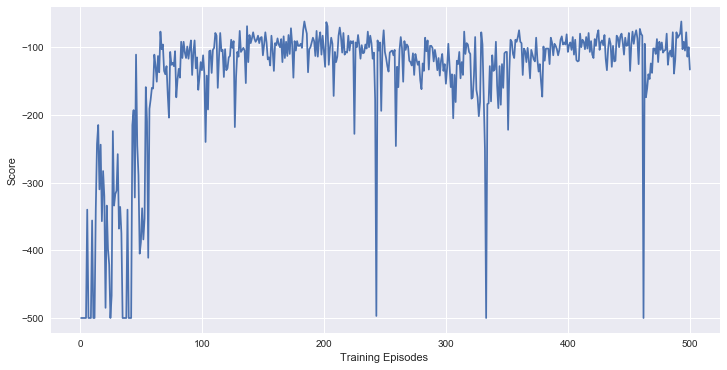

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(dqn.scores)+1), dqn.scores)
plt.xlabel('Training Episodes ')
plt.ylabel('Score')
plt.show()